In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

The set of differential equations that we are modeling are:

\begin{align}
\frac{dV}{dt} &= F_i - F_e \\
\frac{dc_x}{dt} &= \mu_Xc_X\frac{c_S}{K_S+c_S}e^{-K_pc_p} - \frac{F_e}{V}c_X \\
\frac{dc_P}{dt} &= \mu_Pc_X\frac{c_S}{K_{S1}+c_S}e^{-K_{P1}c_P} - \frac{F_e}{V}c_P \\
\frac{dc_S}{dt} &= -\frac{1}{R_{SX}}\mu_Xc_X\frac{c_S}{K_S+c_S}e^{-K_Pc_P} - \frac{1}{R_{SP}}\mu_Pc_X\frac{c_S}{K_{S1}c_P}e^{-K_{P1}c_P}+\frac{F_i}{V}c_{S,in} - \frac{F_e}{V}c_S \\
\frac{dc_{O_2}}{dt} &= (k_la)(c_{O_2}^* - c_{O_2}) - r_{O_2} \\
\frac{dT_r}{dt} &= \frac{F_i}{V}(T_{in}) - \frac{F_e}{V}(T_r) + \frac{r_{O_2}\Delta H_r}{32\rho_r C_{heat, r}} + \frac{K_TA_T(T_r-T_{ag})}{V\rho_rC_{heat,r}} \\
\frac{dT_{ag}}{dt} &= \frac{F_{ag}}{V_j}(T_{in,ag}-T_{ag}) + \frac{K_TA_T(T_r-T_{ag})}{V_j\rho_{ag}C_{heat,ag}}
\end{align}

In [ ]:
# ALL PARAMS

m_NaCl = 500 #g
m_CaCO3 = 100 #g
m_MgCl2 = 100 #g
pH = 6 #of liquid phase
F_i = 51 #L/h
F_e = 51 #L/h
c_Sin = 60 #g/L
T_in = 273 + 25 # K
T_inag = 273 + 15 # K

A_1 = 9.5e8
A_2 = 2.55e33
A_T = 1 #m2
C_heatag = 4.18 #J/g/K
C_heatr = 4.18 #J/g/K
E_a1 = 55000 #J/mol
E_a2 = 220000 #J/mol
H_Na = -0.550
H_Ca = -0.303
H_Mg = -0.314
H_H = -0.774
H_Cl = 0.844
H_CO3 = 0.485
H_HO = 0.941
kla_0 = 38 #1/hr
K_O2 = 8.86 #mg/L
K_P =  0.139 #g/L
K_P1 = 0.070 #g/L
K_S = 1.030 #g/L
K_S1 = 1.680 #g/L
K_T = 3.6e5 #J/h/m2/K
R_SP = 0.435
R_SX = 0.607
V = 1000 #L
V_j = 50 #L
Y_O2 = 0.970 #mg/mg
deltaH_r = 518 #kJ/molO2
mu_O2 = 0.5 #1/hr
mu_P = 1.790 #1/hr
rho_ag = 1000 #g/L
rho_r = 1080 #g/L

# gas constant
Rg = 8.314 # J/mol K

# molar masses (g/mol)
M_Na = 22.99 
M_NaCl = 58.44
M_Ca = 40.08
M_CaCO3 = 100.09
M_Mg = 24.31
M_MgCl2 = 95.21
M_Cl = 35.45
M_CO3 = 60.01

F_ag = 18 #L/h # compute later or keep it as constant value?

In [ ]:
# molar concentration calculations (ions)
c_Na = m_NaCl*M_Na / (M_NaCl*V)
c_Ca = m_CaCO3*M_Ca / (M_CaCO3*V)
c_Mg = m_MgCl2*M_Mg / (M_MgCl2*V)
c_Cl = (m_NaCl/M_NaCl + 2*m_MgCl2/M_MgCl2) * M_Cl/V
c_CO3 = m_CaCO3*M_CO3 / (M_CaCO3*V)
# concentration from pH
c_H = 10**(-pH)
c_OH = 10**(pH-14)

# Ionic strength calculations (Eq 18)
I_Na = 0.5*c_Na
I_Ca = 0.5*c_Ca*(2**2)
I_Mg = 0.5*c_Mg*(2**2)
I_Cl = 0.5*c_Cl
I_CO3 = 0.5*c_CO3*(2**2)
I_H = 0.5*c_H
I_OH = 0.5*c_OH

# global effect of ionic strengths (Eq 26)
ionic_strengths = np.array ([I_Na, I_Ca, I_Mg, I_Cl, I_CO3, I_H, I_OH])
Hs = np.array ([H_Na, H_Ca, H_Mg, H_Cl, H_CO3, H_H, H_HO])

global_eff = np.dot (ionic_strengths, Hs)

In [ ]:
def get_kla (T_r):
  """
  T_r : Reaction Temperature in Kelvin
  """
  T_r = T_r - 273 # conversion to celsius

  # (Eq 27) equilibrium conc of O2 in H2O
  Cstar_0 = 14.6 - 0.3943*T_r + 7.714e-3*(T_r**2) - 6.46e-5*(T_r**3)

  # (Eq 28)
  Cstar = Cstar_0 * 10**(-global_eff) 

  # (Eq 29)
  kla = kla_0 * 1.024**(T_r-20)
  return kla, Cstar

# (Eq 31)
mu_x = lambda T_r: A_1*np.exp(-E_a1/(Rg*T_r)) - A_2*np.exp(-E_a2/(Rg*T_r)) # max specific growth rate as a function of reaction T


In [ ]:
def odes (t, variables, inputs):
  V, Cx, Cp, Cs, Co2, T_r, T_ag = variables
  c_Sin, T_in, T_inag, F_ag, F_i, F_e = inputs

  dVdt = F_i - F_e
  dCxdt = mu_x(T_r) * Cx * Cs * np.exp(-K_P*Cp) / (K_S+Cs) - F_e*Cx/V
  dCpdt = mu_P * Cx * Cs * np.exp(-K_P1*Cp) / (K_S1+Cs) - F_e*Cp/V
  dCsdt = (-mu_x(T_r) * Cx * Cs * np.exp(-K_P*Cp) / (K_S+Cs) / R_SX) - (mu_P * Cx * Cs * np.exp(-K_P1*Cp) / (K_S1+Cs) / R_SP) + (F_i*c_Sin - F_e*Cs)/V
  
  # (Eq 30)
  r_o2 = mu_O2 * Cx * Co2 / (Y_O2 * (K_O2+Co2))
  kla, Cstar = get_kla (T_r)
  # (Eq 36)
  dCo2dt = kla * (Cstar-Co2) - 1000*r_o2

  # (Eq 37,38)
  dTrdt = (F_i*T_in - F_e*T_r)/V + r_o2*deltaH_r/(32*rho_r*C_heatr) + (K_T*A_T*(T_r-T_ag))/(V*rho_r*C_heatr)
  dTagdt = F_ag*(T_inag-T_ag)/V_j + (K_T*A_T*(T_r-T_ag))/(V_j*rho_ag*C_heatag)

  return [dVdt, dCxdt, dCpdt, dCsdt, dCo2dt, dTrdt, dTagdt]

def solve_sys (vars0, inputs):
  tspan = (0, 300) # hrs
  teval = np.linspace (*tspan, 500)
  sol = solve_ivp (odes, tspan, vars0, t_eval=teval, args=[inputs], method='Radau')
  return sol.t, sol.y

We first determine the steady-state operating conditions at nominal values of the inputs.

The steady-state value of Cx is 0.854925429545349.
The steady-state value of Cp is 12.151468779455367.
The steady-state value of Cs is 30.657145594794873.
The steady-state value of C_O2 is 3.4583202041918066.
The steady-state value of Tr is 28.71621958284129.
The steady-state value of Tag is 26.345094213227185.


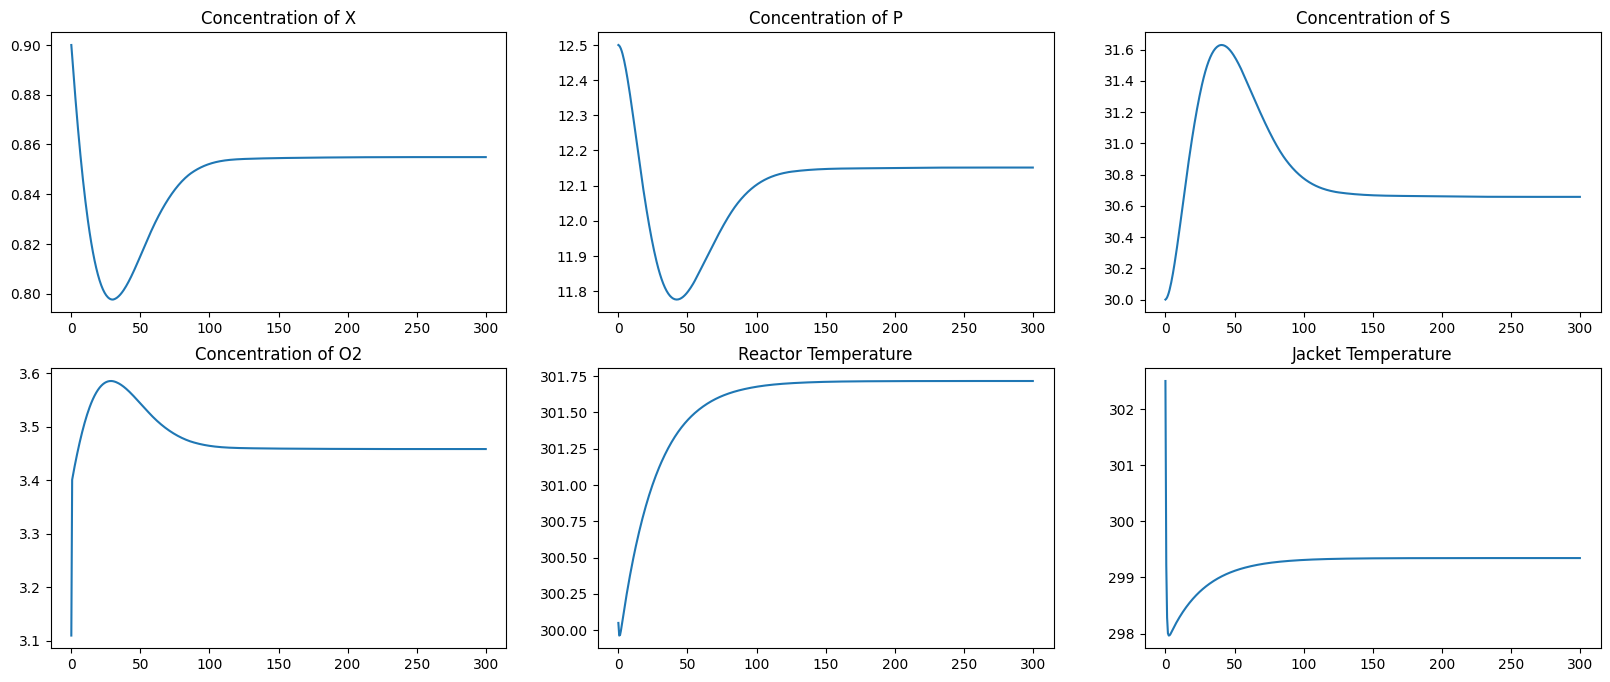

In [ ]:
c_Sin = 60 #g/L
T_in = 273 + 25 #K
T_inag = 273 + 15 #K
F_ag = 18 #L/h
F_i = F_e = 51 #L/h

fig,ax = plt.subplots (2, 3, figsize=(20,8))

initial_values = np.array([V, 0.9, 12.5, 30, 3.11, 273+27.05, 273+29.5])
inputs = np.array([c_Sin, T_in, T_inag, F_ag, F_i, F_e])

t, y = solve_sys(initial_values, inputs)

ax[0][0].plot(t, y[1])
ax[0][0].set_title('Concentration of X')
print(f'The steady-state value of Cx is {y[1][-1]}.')

ax[0][1].plot(t, y[2])
ax[0][1].set_title('Concentration of P')
print(f'The steady-state value of Cp is {y[2][-1]}.')

ax[0][2].plot(t, y[3])
ax[0][2].set_title('Concentration of S')
print(f'The steady-state value of Cs is {y[3][-1]}.')

ax[1][0].plot(t, y[4])
ax[1][0].set_title('Concentration of O2')
print(f'The steady-state value of C_O2 is {y[4][-1]}.')

ax[1][1].plot(t, y[5])
ax[1][1].set_title('Reactor Temperature')
print(f'The steady-state value of Tr is {y[5][-1] - 273}.')

ax[1][2].plot(t, y[6])
ax[1][2].set_title('Jacket Temperature')
print(f'The steady-state value of Tag is {y[6][-1] - 273}.')

#make an array of these steady-state values
nominal_SS_vals = np.array([y[i][-1] for i in range(len(y))])

We perform a step in c_Sin, from 60 to 40.

The steady-state value of Cx is 0.87636280801926.
The steady-state value of Cp is 11.771934690673707.
The steady-state value of Cs is 11.494328444689952.
The steady-state value of C_O2 is 3.415932422992465.
The steady-state value of Tr is 28.716446431731356.
The steady-state value of Tag is 26.345282407375123.


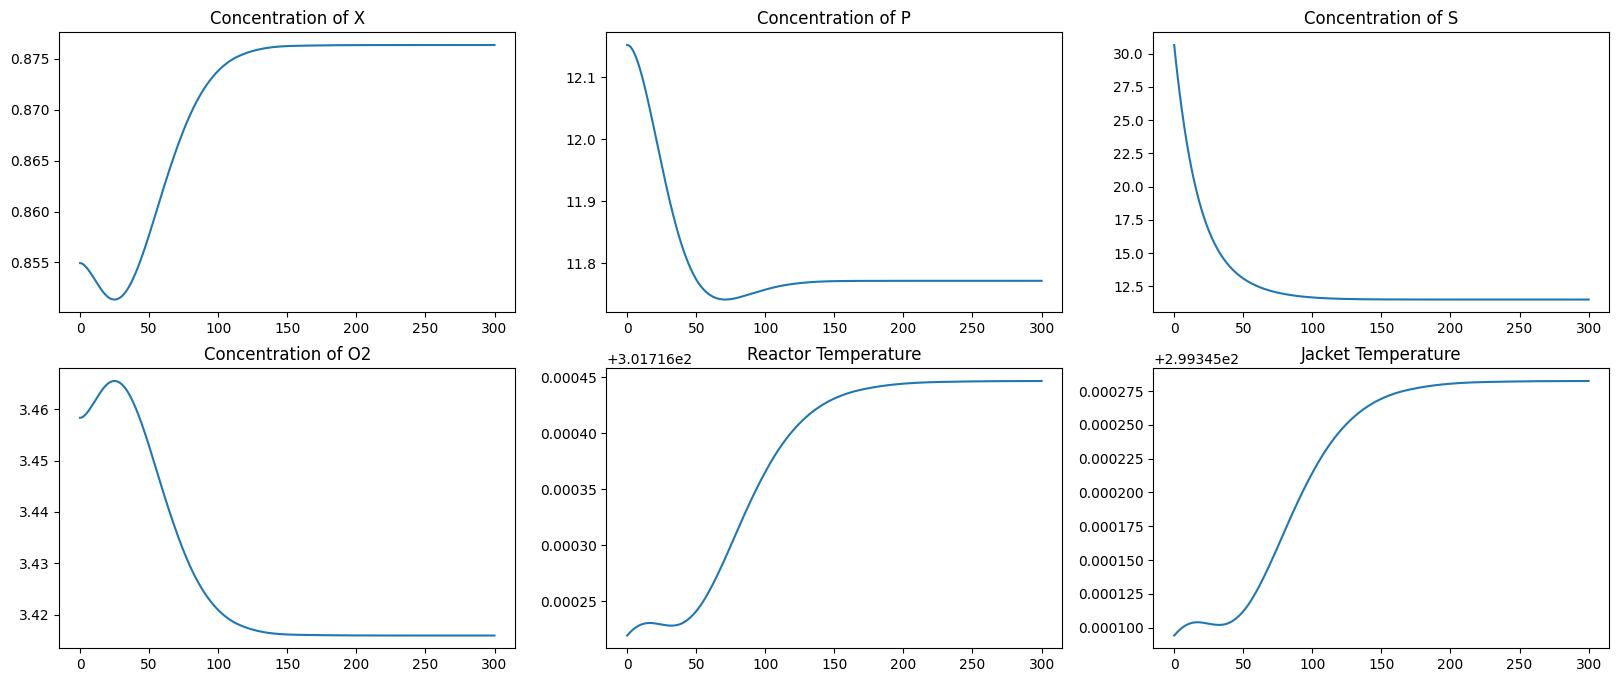

In [ ]:
c_Sin = 40 #g/L
T_in = 273 + 25 #K
T_inag = 273 + 15 #K
F_ag = 18 #L/h
F_i = F_e = 51 #L/h

fig,ax = plt.subplots (2, 3, figsize=(20,8))

initial_values = nominal_SS_vals
inputs = np.array([c_Sin, T_in, T_inag, F_ag, F_i, F_e])

t, y = solve_sys(initial_values, inputs)

ax[0][0].plot(t, y[1])
ax[0][0].set_title('Concentration of X')
print(f'The steady-state value of Cx is {y[1][-1]}.')

ax[0][1].plot(t, y[2])
ax[0][1].set_title('Concentration of P')
print(f'The steady-state value of Cp is {y[2][-1]}.')

ax[0][2].plot(t, y[3])
ax[0][2].set_title('Concentration of S')
print(f'The steady-state value of Cs is {y[3][-1]}.')

ax[1][0].plot(t, y[4])
ax[1][0].set_title('Concentration of O2')
print(f'The steady-state value of C_O2 is {y[4][-1]}.')

ax[1][1].plot(t, y[5])
ax[1][1].set_title('Reactor Temperature')
print(f'The steady-state value of Tr is {y[5][-1] - 273}.')

ax[1][2].plot(t, y[6])
ax[1][2].set_title('Jacket Temperature')
print(f'The steady-state value of Tag is {y[6][-1] - 273}.')

We then do a step in T_in, from 25 to 23.

The steady-state value of Cx is 0.6796352179202109.
The steady-state value of Cp is 10.72921239516212.
The steady-state value of Cs is 34.215481286662744.
The steady-state value of C_O2 is 3.902169279129997.
The steady-state value of Tr is 25.97382317659259.
The steady-state value of Tag is 24.076777354608396.


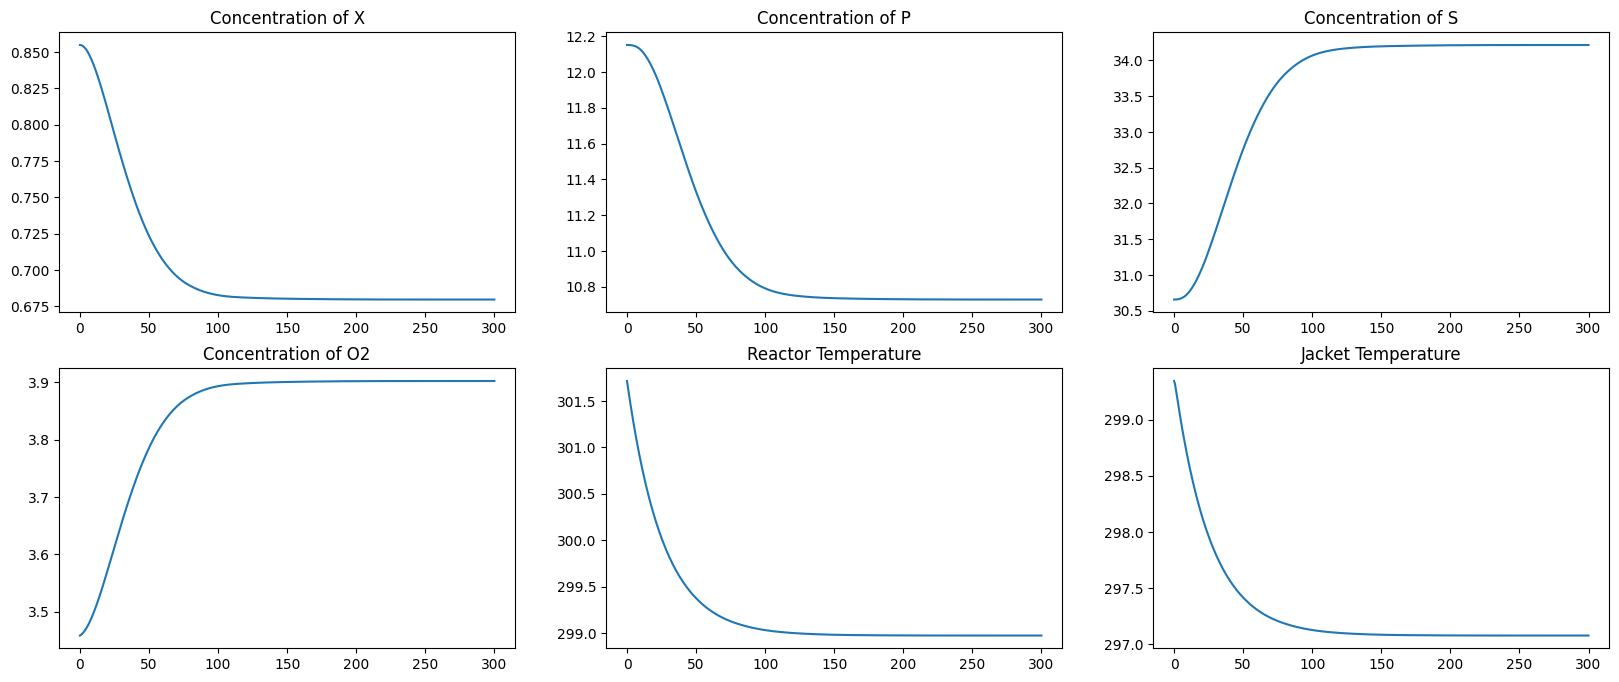

In [ ]:
c_Sin = 60 #g/L
T_in = 273 + 23 #K
T_inag = 273 + 15 #K
F_ag = 18 #L/h
F_i = F_e = 51 #L/h

fig,ax = plt.subplots (2, 3, figsize=(20,8))

initial_values = nominal_SS_vals
inputs = np.array([c_Sin, T_in, T_inag, F_ag, F_i, F_e])

t, y = solve_sys(initial_values, inputs)

ax[0][0].plot(t, y[1])
ax[0][0].set_title('Concentration of X')
print(f'The steady-state value of Cx is {y[1][-1]}.')

ax[0][1].plot(t, y[2])
ax[0][1].set_title('Concentration of P')
print(f'The steady-state value of Cp is {y[2][-1]}.')

ax[0][2].plot(t, y[3])
ax[0][2].set_title('Concentration of S')
print(f'The steady-state value of Cs is {y[3][-1]}.')

ax[1][0].plot(t, y[4])
ax[1][0].set_title('Concentration of O2')
print(f'The steady-state value of C_O2 is {y[4][-1]}.')

ax[1][1].plot(t, y[5])
ax[1][1].set_title('Reactor Temperature')
print(f'The steady-state value of Tr is {y[5][-1] - 273}.')

ax[1][2].plot(t, y[6])
ax[1][2].set_title('Jacket Temperature')
print(f'The steady-state value of Tag is {y[6][-1] - 273}.')

We do a step in T_inag, from 15 to 13.

The steady-state value of Cx is 0.9068218095329701.
The steady-state value of Cp is 12.530632701948402.
The steady-state value of Cs is 29.700007433494882.
The steady-state value of C_O2 is 3.3487158503157044.
The steady-state value of Tr is 29.457529223921426.
The steady-state value of Tag is 26.612513416660022.


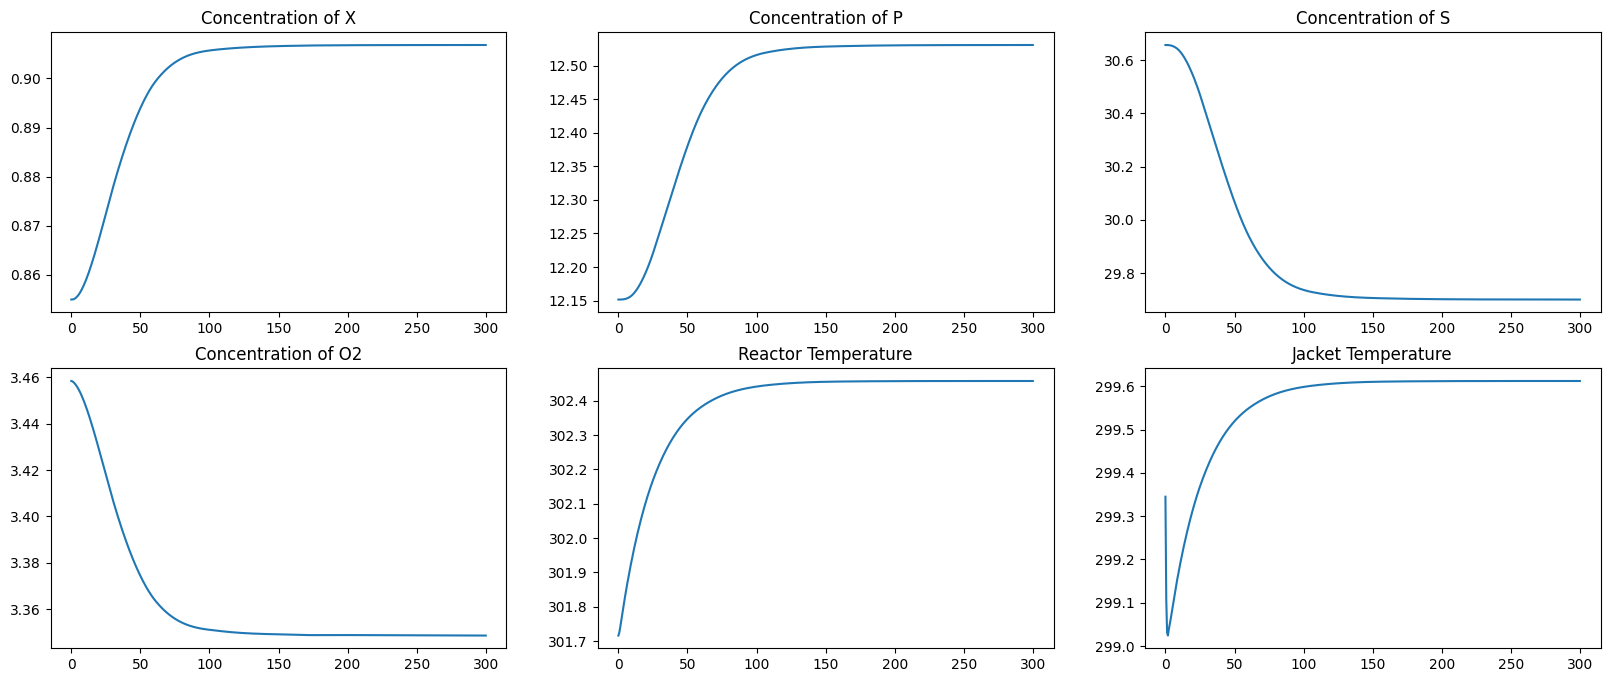

In [ ]:
c_Sin = 60 #g/L
T_in = 273 + 25 #K
T_inag = 273 + 13 #K
F_ag = 18 #L/h
F_i = F_e = 51 #L/h

fig,ax = plt.subplots (2, 3, figsize=(20,8))

initial_values = nominal_SS_vals
inputs = np.array([c_Sin, T_in, T_inag, F_ag, F_i, F_e])

t, y = solve_sys(initial_values, inputs)

ax[0][0].plot(t, y[1])
ax[0][0].set_title('Concentration of X')
print(f'The steady-state value of Cx is {y[1][-1]}.')

ax[0][1].plot(t, y[2])
ax[0][1].set_title('Concentration of P')
print(f'The steady-state value of Cp is {y[2][-1]}.')

ax[0][2].plot(t, y[3])
ax[0][2].set_title('Concentration of S')
print(f'The steady-state value of Cs is {y[3][-1]}.')

ax[1][0].plot(t, y[4])
ax[1][0].set_title('Concentration of O2')
print(f'The steady-state value of C_O2 is {y[4][-1]}.')

ax[1][1].plot(t, y[5])
ax[1][1].set_title('Reactor Temperature')
print(f'The steady-state value of Tr is {y[5][-1] - 273}.')

ax[1][2].plot(t, y[6])
ax[1][2].set_title('Jacket Temperature')
print(f'The steady-state value of Tag is {y[6][-1] - 273}.')

We do a step in F_ag, from 18 to 20.

The steady-state value of Cx is 0.8878903307903766.
The steady-state value of Cp is 12.394234538733766.
The steady-state value of Cs is 30.04475502696555.
The steady-state value of C_O2 is 3.387785785427447.
The steady-state value of Tr is 29.19052248184579.
The steady-state value of Tag is 26.51620386620789.


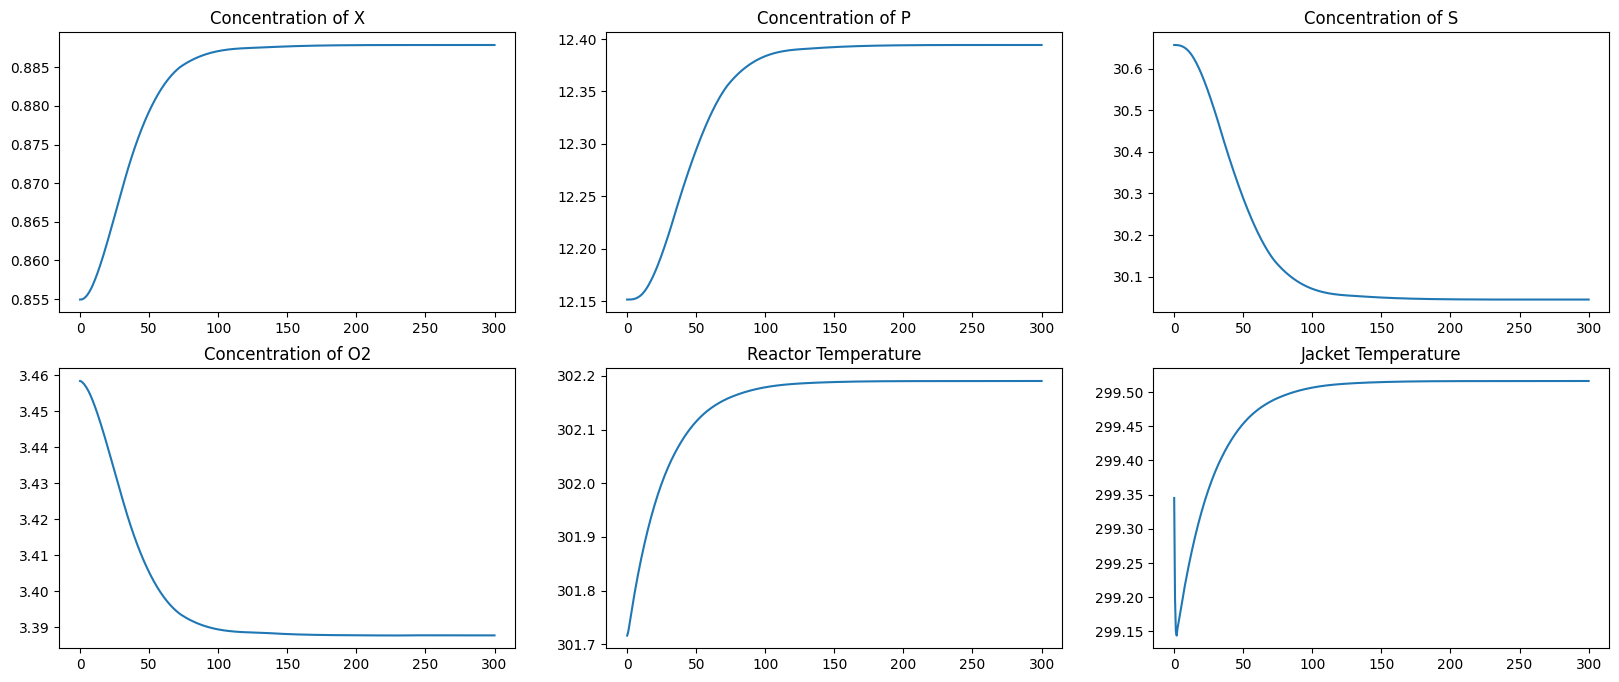

In [ ]:
c_Sin = 60 #g/L
T_in = 273 + 25 #K
T_inag = 273 + 15 #K
F_ag = 20 #L/h
F_i = F_e = 51 #L/h

fig,ax = plt.subplots (2, 3, figsize=(20,8))

initial_values = nominal_SS_vals
inputs = np.array([c_Sin, T_in, T_inag, F_ag, F_i, F_e])

t, y = solve_sys(initial_values, inputs)

ax[0][0].plot(t, y[1])
ax[0][0].set_title('Concentration of X')
print(f'The steady-state value of Cx is {y[1][-1]}.')

ax[0][1].plot(t, y[2])
ax[0][1].set_title('Concentration of P')
print(f'The steady-state value of Cp is {y[2][-1]}.')

ax[0][2].plot(t, y[3])
ax[0][2].set_title('Concentration of S')
print(f'The steady-state value of Cs is {y[3][-1]}.')

ax[1][0].plot(t, y[4])
ax[1][0].set_title('Concentration of O2')
print(f'The steady-state value of C_O2 is {y[4][-1]}.')

ax[1][1].plot(t, y[5])
ax[1][1].set_title('Reactor Temperature')
print(f'The steady-state value of Tr is {y[5][-1] - 273}.')

ax[1][2].plot(t, y[6])
ax[1][2].set_title('Jacket Temperature')
print(f'The steady-state value of Tag is {y[6][-1] - 273}.')

Finally, we do a step in both F_i and F_e, from 51 to 55.

The steady-state value of Cx is 0.8224947279838718.
The steady-state value of Cp is 11.431762764876739.
The steady-state value of Cs is 32.36506957165213.
The steady-state value of C_O2 is 3.5294664305443324.
The steady-state value of Tr is 28.35532897212289.
The steady-state value of Tag is 26.04659144092267.


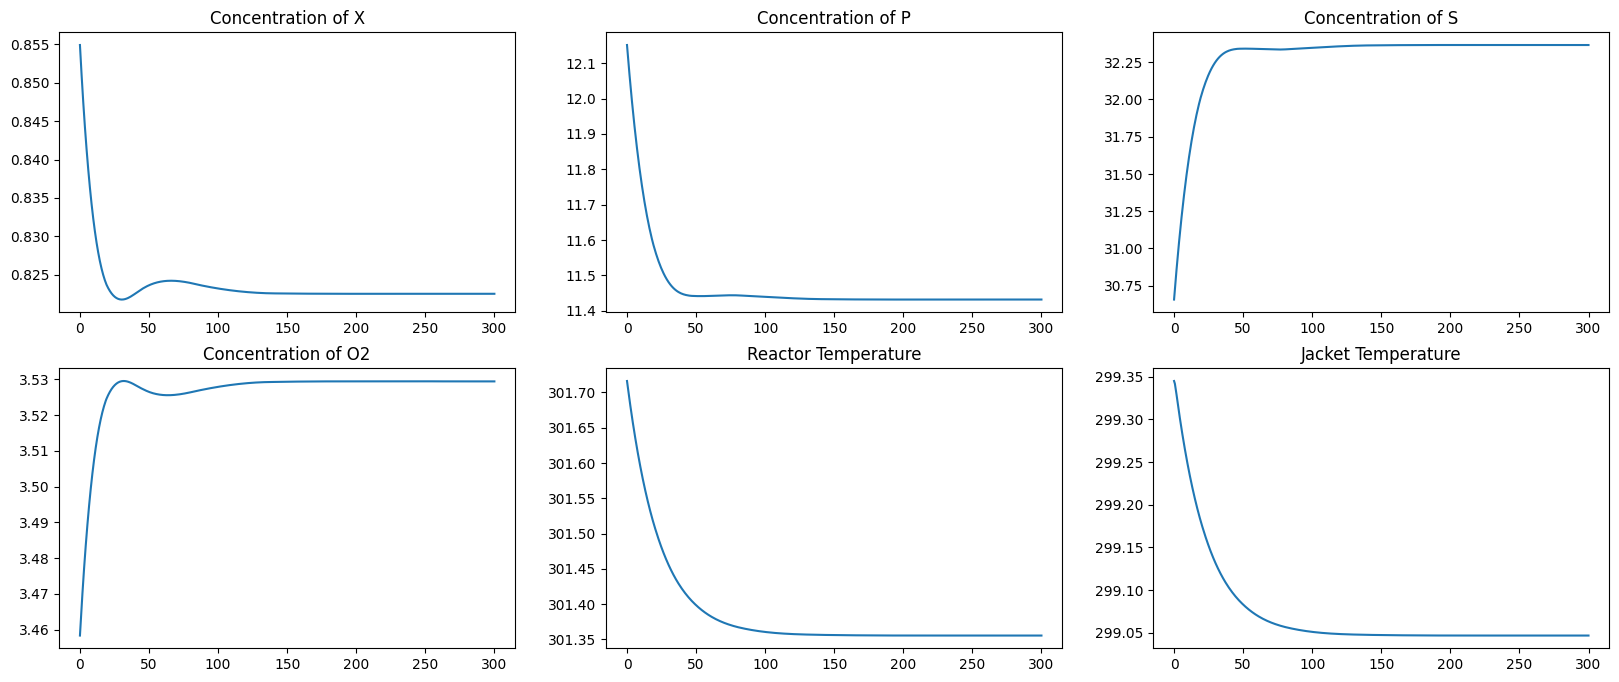

In [ ]:
c_Sin = 60 #g/L
T_in = 273 + 25 #K
T_inag = 273 + 15 #K
F_ag = 18 #L/h
F_i = F_e = 55 #L/h

fig,ax = plt.subplots (2, 3, figsize=(20,8))

initial_values = nominal_SS_vals
inputs = np.array([c_Sin, T_in, T_inag, F_ag, F_i, F_e])

t, y = solve_sys(initial_values, inputs)

ax[0][0].plot(t, y[1])
ax[0][0].set_title('Concentration of X')
print(f'The steady-state value of Cx is {y[1][-1]}.')

ax[0][1].plot(t, y[2])
ax[0][1].set_title('Concentration of P')
print(f'The steady-state value of Cp is {y[2][-1]}.')

ax[0][2].plot(t, y[3])
ax[0][2].set_title('Concentration of S')
print(f'The steady-state value of Cs is {y[3][-1]}.')

ax[1][0].plot(t, y[4])
ax[1][0].set_title('Concentration of O2')
print(f'The steady-state value of C_O2 is {y[4][-1]}.')

ax[1][1].plot(t, y[5])
ax[1][1].set_title('Reactor Temperature')
print(f'The steady-state value of Tr is {y[5][-1] - 273}.')

ax[1][2].plot(t, y[6])
ax[1][2].set_title('Jacket Temperature')
print(f'The steady-state value of Tag is {y[6][-1] - 273}.')